# Direct Marketing with Amazon SageMaker Autopilot

1. Introduction

- Amazon SageMaker Autopilot은 tabular datasets을 위한 자동화된 ML training solution (AutoML)
- Bank Marketing Data Set을 이용하여, 하나 이상의 전화 통화 후에 은행에 정기 예금에 등록할 것 인지 여부를 예측하는 ML Training의 일반적인 introductory task
- Autopilot을 사용하여, 여러 가지 잠재적인 옵션 또는 후보를 탐색하여 가장 정확한 ML Pipeline을 얻는 방법을 보여줌
- Autopilot에 의해 생성된 각 후보들은 2단계로 구성
    - 데이터 세트에서 자동화된 기능 엔지니어링 수행
    - 모델을 생성하기 위한 알고리즘 훈련 및 조정

2. Prerequisites

In [1]:
import sagemaker
import boto3


region = boto3.Session().region_name
print("region: ", region)

session = sagemaker.Session()
bucket = session.default_bucket()
prefix = 'sagemaker/autopilot-dm'
print("s3 path: ", bucket + '/' + prefix)

region:  ap-northeast-2
s3 path:  sagemaker-ap-northeast-2-988889742134/sagemaker/autopilot-dm


In [2]:
role = sagemaker.get_execution_role()

sm = boto3.Session().client(
    service_name="sagemaker",
    region_name=region
)

3. Downloading the dataset

In [4]:
!wget -N https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
!conda install -y -c conda-forge unzip
!unzip -o bank-additional.zip

local_data_path = './bank-additional/bank-additional-full.csv'

--2022-04-28 07:28:28--  https://sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com/autopilot/direct_marketing/bank-additional.zip
Resolving sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)... 52.218.245.145
Connecting to sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com (sagemaker-sample-data-us-west-2.s3-us-west-2.amazonaws.com)|52.218.245.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432828 (423K) [application/zip]
Saving to: ‘bank-additional.zip’

bank-additional.zip 100%[===================>] 422.68K   838KB/s    in 0.5s    

2022-04-28 07:28:29 (838 KB/s) - ‘bank-additional.zip’ saved [432828/432828]

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - unzip


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------

4. EDA

- 데이터 세트에서 Autopilot을 실행하기 전에 먼저 데이터 세트에 명백한 오류가 없는 지 확인해야 함
- Autopilot process는 시간이 오래 걸릴 수 있으므로, 일반적으로 작업을 시작하기 전 데이터 세트를 검사하는 것이 좋음
- 현재 실습에 이용되는 데이터 세트는 작기 때문에, 현재 실습이 진행되는 notebook instance에서 데이터 세트 검사 가능
- _**Autopilot은 최대 5GB의 데이터 셋에 대해 처리할 수 있음**_

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


local_data_path = './bank-additional/bank-additional-full.csv'

data = pd.read_csv(local_data_path)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10)

In [5]:
data.shape

(41188, 21)

In [6]:
data.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
columns = data.columns.to_list()

In [8]:
dtypes = data.dtypes.to_list()

In [9]:
data.isnull().sum().to_list()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [10]:
for col, dtyp in zip(columns, dtypes):
    print(col, " : ", dtyp)

age  :  int64
job  :  object
marital  :  object
education  :  object
default  :  object
housing  :  object
loan  :  object
contact  :  object
month  :  object
day_of_week  :  object
duration  :  int64
campaign  :  int64
pdays  :  int64
previous  :  int64
poutcome  :  object
emp.var.rate  :  float64
cons.price.idx  :  float64
cons.conf.idx  :  float64
euribor3m  :  float64
nr.employed  :  float64
y  :  object


5. Reserve som data for calling batch inference on tha model

In [11]:
train_data = data.sample(frac=0.8, random_state=200)

test_data = data.drop(train_data.index)

test_data_no_target = test_data.drop(columns=['y'])

In [12]:
train_data.shape

(32950, 21)

In [13]:
test_data.shape

(8238, 21)

In [14]:
test_data_no_target.shape

(8238, 20)

6. Upload the dataset to Amazon S3

In [38]:
train_file = 'train_data.csv'

train_data.to_csv(
    train_file,
    index=False,
    header=True
)

train_data_s3_path = session.upload_data(
    path=train_file,
    key_prefix=prefix + "/train"
)
print("Train data uploaded to: ", train_data_s3_path)

Train data uploaded to:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/autopilot-dm/train/train_data.csv


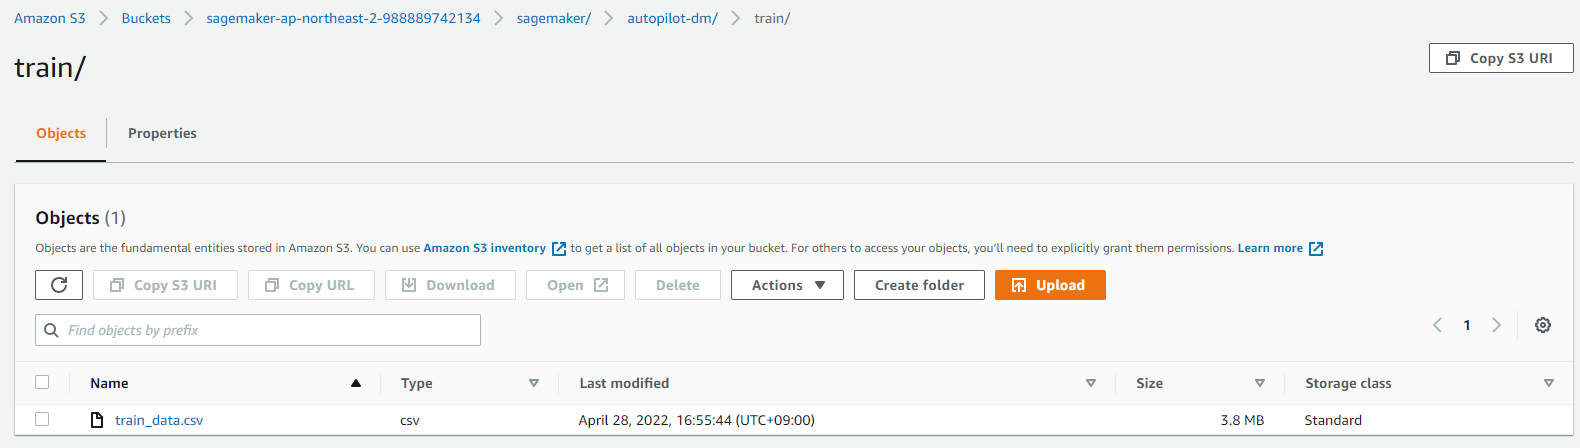

In [39]:
test_file = 'test_data.csv'

test_data_no_target.to_csv(
    test_file,
    index=False,
    header=False
)

test_data_s3_path = session.upload_data(
    path=test_file, key_prefix=prefix + "/test"
)
print("Test data uploaded to: ", test_data_s3_path)

Test data uploaded to:  s3://sagemaker-ap-northeast-2-988889742134/sagemaker/autopilot-dm/test/test_data.csv


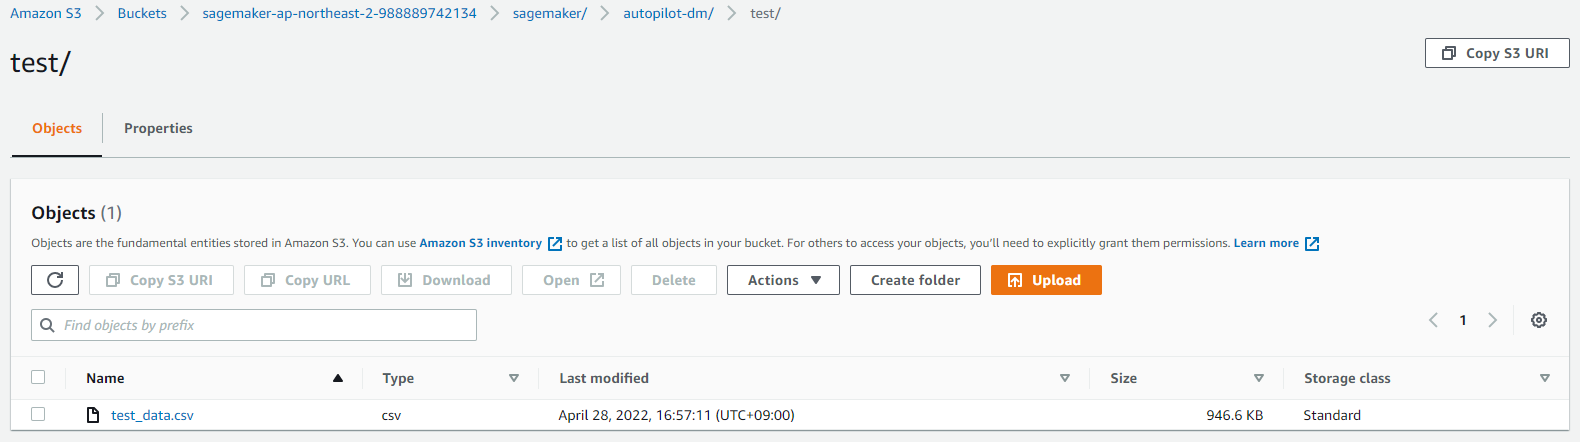

7. Setting up the SageMaker Autopilot Job

Amazon S3에 train, test dataset을 업로드 후, 해당 dataset을 training하여 도출된 ML Pipeline의 best candidate를 찾기 위해 Autopilot Job 실행

The required inputs for invoking a Autopilot job
- Autopilot job이 수행되기 위한 input dataset의 s3 경로
- Autopilot job이 수행되고, 도출된 모든 output artifacts를 저장할 s3 경로
- Autopilot job이 수행되면서, prediction을 하는 target column의 name
- Autopilot job을 수행하기 위한 IAM role
- Autopilot job을 수행하는데 필요한 ML Problem의 type 정의
- Autopilot job을 수행한 후, 도출할 candidataes의 max 값
- Autopilot job을 수행하면서, 각 candidates의 결과 지표 정의

_**현재 Autopiloe은 오직 csv format의 tabular dataset을 지원**_

In [15]:
# Input data configuration

input_data_config = [
    {
        'DataSource': {
            'S3DataSource': {
                'S3DataType': 'S3Prefix',
                'S3Uri': 's3://{}/{}/train'.format(bucket, prefix)
            }
        },
        'TargetAttributeName': 'y'
    }
]

In [16]:
# Output data configuration

output_data_config = {
    'S3OutputPath': 's3://{}/{}/output'.format(bucket, prefix)
}

In [17]:
# AutoML Job Max Candidates

autoMLJobConfig = {
    'CompletionCriteria': {
        'MaxCandidates': 5
    }
}

In [18]:
# AutoMl Job Metric

autoMLJobObjective = {
    'MetricName': 'Accuracy'
}

8. Launching the SageMaker Autopilot Job

In [19]:
from time import gmtime, strftime, sleep


timestamp_suffix = strftime('%m-%d-%H-%M-%S', gmtime())
print("Timestamp: ", timestamp_suffix)

Timestamp:  04-29-01-58-22


In [20]:
auto_ml_job_name = 'automl-banking-' + timestamp_suffix
print('AutoMLJobName: ', auto_ml_job_name)

AutoMLJobName:  automl-banking-04-29-01-58-22


In [21]:
sm.create_auto_ml_job(
    AutoMLJobName=auto_ml_job_name,
    InputDataConfig=input_data_config,
    OutputDataConfig=output_data_config,
    AutoMLJobConfig=autoMLJobConfig,
    AutoMLJobObjective=autoMLJobObjective,
    ProblemType="BinaryClassification",
    RoleArn=role
)

{'AutoMLJobArn': 'arn:aws:sagemaker:ap-northeast-2:988889742134:automl-job/automl-banking-04-29-01-58-22',
 'ResponseMetadata': {'RequestId': '3ec26ca0-c3a0-427d-b1dc-13738a32a13a',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3ec26ca0-c3a0-427d-b1dc-13738a32a13a',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '105',
   'date': 'Fri, 29 Apr 2022 01:58:26 GMT'},
  'RetryAttempts': 0}}

9. Tracking SageMaker Autopilot job progress

In [24]:
print ('JobStatus - Secondary Status')
print('------------------------------')


describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
job_run_status = describe_response['AutoMLJobStatus']
    
while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_auto_ml_job(AutoMLJobName=auto_ml_job_name)
    job_run_status = describe_response['AutoMLJobStatus']
    
    print (describe_response['AutoMLJobStatus'] + " - " + describe_response['AutoMLJobSecondaryStatus'])
    sleep(30)

JobStatus - Secondary Status
------------------------------
Completed - Completed


10. Results

In [27]:
best_candidate = sm.describe_auto_ml_job(
    AutoMLJobName=auto_ml_job_name
)['BestCandidate']

best_candidate_name = best_candidate['CandidateName']
print("CandidateName: ", best_candidate_name)
print("FinalAutoMLJobObjectiveMetricName: ", best_candidate['FinalAutoMLJobObjectiveMetric']['MetricName'])
print("FinalAutoMLJobObjectiveMetricValue: ", str(best_candidate['FinalAutoMLJobObjectiveMetric']['Value']))

CandidateName:  automl-banking-04-29-01-58-22sob-002-04637d18
FinalAutoMLJobObjectiveMetricName:  validation:accuracy
FinalAutoMLJobObjectiveMetricValue:  0.915090024471283


11. Perform batch inference using the best candidate

In [28]:
model_name = 'automl-banking-model-' + timestamp_suffix
print("model name: ", model_name)

model name:  automl-banking-model-04-29-01-58-22


In [29]:
model = sm.create_model(
    Containers=best_candidate['InferenceContainers'],
    ModelName=model_name,
    ExecutionRoleArn=role
)

In [30]:
print('Model ARN corresponding to the best candidate is : {}'.format(model['ModelArn']))

Model ARN corresponding to the best candidate is : arn:aws:sagemaker:ap-northeast-2:988889742134:model/automl-banking-model-04-29-01-58-22


Amazon SageMaker Batch Transform을 사용하여, batch inference

In [36]:
transform_job_name = 'automl-banking-transform-' + timestamp_suffix

test_data_s3_path = 's3://sagemaker-ap-northeast-2-988889742134/sagemaker/autopilot-dm/test/test_data.csv'

transform_input = {
    'DataSource': {
        'S3DataSource': {
            'S3DataType': 'S3Prefix',
            'S3Uri': test_data_s3_path
        }
    },
    'ContentType': 'text/csv',
    'CompressionType': 'None',
    'SplitType': 'Line'
}

In [37]:
transform_output = {
    'S3OutputPath': 's3://{}/{}/inference-results'.format(bucket, prefix)
}

In [38]:
transform_resources = {
    'InstanceType': 'ml.m5.4xlarge',
    'InstanceCount': 1
}

In [39]:
sm.create_transform_job(
    TransformJobName=transform_job_name,
    ModelName=model_name,
    TransformInput=transform_input,
    TransformOutput=transform_output,
    TransformResources=transform_resources
)

{'TransformJobArn': 'arn:aws:sagemaker:ap-northeast-2:988889742134:transform-job/automl-banking-transform-04-29-01-58-22',
 'ResponseMetadata': {'RequestId': '8da7d09f-8426-40da-8468-660cd2bca0d8',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '8da7d09f-8426-40da-8468-660cd2bca0d8',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '121',
   'date': 'Fri, 29 Apr 2022 04:41:29 GMT'},
  'RetryAttempts': 0}}

Watch the transform job for completion

In [41]:
print('JobStatus')
print('-----------')


describe_response = sm.describe_transform_job(
    TransformJobName=transform_job_name
)

job_run_status = describe_response['TransformJobStatus']
print(job_run_status)

while job_run_status not in ('Failed', 'Completed', 'Stopped'):
    describe_response = sm.describe_transform_job(
        TransformJobName=transform_job_name
    )
    job_run_status = describe_response['TransformJobStatus']
    print(job_run_status)
    sleep(30)

JobStatus
-----------
InProgress
InProgress
Completed


In [42]:
s3_output_key = '{}/inference-results/test_data.csv.out'.format(prefix)
print("s3 output key: ", s3_output_key)

s3 output key:  sagemaker/autopilot-dm/inference-results/test_data.csv.out


In [43]:
local_inference_results_path = 'inference_results.csv'

In [45]:
s3_resource = boto3.resource('s3')
inference_results_bucket = s3_resource.Bucket(session.default_bucket())

inference_results_bucket.download_file(
    s3_output_key,
    local_inference_results_path
)

In [46]:
data = pd.read_csv(local_inference_results_path, sep=';')
pd.set_option('display.max_rows', 10)

In [47]:
data.head()

,no
0,no
1,no
2,no
3,no
4,no


In [48]:
data.shape

(8237, 1)

12. View other candidates explored by SageMaker Autopilot

In [49]:
candidates = sm.list_candidates_for_auto_ml_job(
    AutoMLJobName=auto_ml_job_name,
    SortBy='FinalObjectiveMetricValue'
)['Candidates']

In [50]:
for idx, candidate in enumerate(candidates):
    print(str(idx+1) + "  " + candidate['CandidateName'] + "  " + str(candidate['FinalAutoMLJobObjectiveMetric']['Value']))
    

1  automl-banking-04-29-01-58-22sob-002-04637d18  0.915090024471283
2  automl-banking-04-29-01-58-22sob-004-5a041399  0.9138799905776978
3  automl-banking-04-29-01-58-22sob-005-07ccd359  0.9133700132369995
4  automl-banking-04-29-01-58-22sob-001-c0692f7f  0.9004552364349365
5  automl-banking-04-29-01-58-22sob-003-70e66371  0.4895295798778534


13. Candidate Generation Notebook

SageMaker Autopilot은 후보 정의 노트북을 자동으로 생성

해당 노트북에서 SageMaker Autopilot이 취한 다양한 단계를 대화식으로 밟아 최적의 후보에게 도달하는데 사용

또한, 노트북은 병렬처리, 사용된 하드웨어, 탐색된 알고리즘, 기능 추출 스크립트 등과 같은 다양한 런타임 매개 변수를 정의하는데 사용

In [60]:
s3_notebook_path = sm.describe_auto_ml_job(
    AutoMLJobName=auto_ml_job_name
)['AutoMLJobArtifacts']['CandidateDefinitionNotebookLocation']

s3_notebook_path_split = s3_notebook_path.split('/')

s3_notebook_path = '/'.join(s3_notebook_path_split[3:])
print(s3_notebook_path)

local_notebook_path = 'autopilot_result_notebook.ipynb'

sagemaker/autopilot-dm/output/automl-banking-04-29-01-58-22/sagemaker-automl-candidates/automl-banking-04-29-01-58-22-pr-1-201355a5892b4fe7b6714a18ddd4/notebooks/SageMakerAutopilotCandidateDefinitionNotebook.ipynb


In [62]:
s3_resource = boto3.resource('s3')
candidate_notebook_bucket = s3_resource.Bucket(session.default_bucket())

candidate_notebook_bucket.download_file(
    s3_notebook_path,
    local_notebook_path
)

14. Data Exploration Notebook

In [69]:
s3_data_explore = sm.describe_auto_ml_job(
    AutoMLJobName=auto_ml_job_name
)['AutoMLJobArtifacts']['DataExplorationNotebookLocation']

s3_data_explore_path_split = s3_data_explore.split('/')

s3_data_explore_path = '/'.join(s3_data_explore_path_split[3:])
print(s3_data_explore_path)

local_data_explore_path = 'autopilot_data_exploration_notebook.ipynb'

sagemaker/autopilot-dm/output/automl-banking-04-29-01-58-22/sagemaker-automl-candidates/automl-banking-04-29-01-58-22-pr-1-201355a5892b4fe7b6714a18ddd4/notebooks/SageMakerAutopilotDataExplorationNotebook.ipynb


In [70]:
s3_resource = boto3.resource('s3')
data_exploration_notebook_bucket = s3_resource.Bucket(session.default_bucket())

data_exploration_notebook_bucket.download_file(
    s3_data_explore_path,
    local_data_explore_path
)

15. Clean up

In [ ]:
#s3 = boto3.resource('s3')
#bucket = s3.Bucket(bucket)

#job_outputs_prefix = '{}/output/{}'.format(prefix,auto_ml_job_name)
#bucket.objects.filter(Prefix=job_outputs_prefix).delete()